# Params

**Imports**

In [49]:
#pip install tqdm

In [50]:
#pip install torchvision

In [51]:
#pip install opencv-python

In [73]:
#Download
     #tqdm
     #torchvision
     #cv2   
#Pytorch dataset 
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from astropy.io import fits
import numpy as np

#Deep Learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
#images#
import cv2
import os
from matplotlib import pyplot as plt

# Drive
#from google.colab import drive
#drive.mount('/content/drive')

**Params Images**

In [74]:
N = 28 # image size
N_PSF = 28 # psf size
TYPE_PSF = 'gauss_128x128' 

**Params Dataset Python**


In [75]:
PATH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/images' #path where the dataset is saved 
PATH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/images' #path where the dataset is saved 
INITIAL_DATASET = 0  #initial index for the names of the saved images 
FINAL_DATASET =   100000#final index for the names of the saved images 

**Params Dataset Python**


In [77]:
PERC_TRAIN = 0.7 # (70%) #training percentage 
PERC_TEST =  0.3 # (30%) #testing percentag
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH = 10 #batch sizeimages 
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
PATH_TRAIN =  'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/train'
PATH_TEST =  'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/test'
PATH_GRAPH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/graph'

**Auxiliary functions**

TODO: comentar

In [78]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, N, N)
    save_image(img, name)

display fit image from a directory

In [79]:
def display_fits(path):
  hdul=fits.open(path)
  hdr = hdul[0].header
  size = hdr[3]
  data = hdul[0].data.astype(np.float32)
  image = np.reshape(data,[size,size])
  plt.imshow(image)

read fit image dataset from a directory


*   `path`: path where the images are
*   `type_image`: *image* (simulated images) or *conv* (dirty images)
*   `size_image`: TODO: comentar
*   `initial`: initial index for the names of the saved images
*   `final`: final index for the names of the saved images

In [80]:
def get_dataset(path,type_image,size_image,initial,final):
  images = []
  #path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(initial)+'.fits'
  #hdul=fits.open(path_file)  
  #hdr = hdul[0].header
  #size = hdr[3]
  for i in range(initial,final):
    path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(i)+'.fits'
    hdul=fits.open(path_file)
    data = hdul[0].data.astype(np.float32)
    image = np.reshape(data,[size_image,size_image])
    images.append(image)
  return images

Function which makes a directory `path`.

In [81]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Pytorch Dataset

**Params**

In [82]:
size = FINAL_DATASET- INITIAL_DATASET  #size of lot of the dataset
size_train = round(size*PERC_TRAIN) 
size_test =  round(size*PERC_TEST)  
batch_size=  BATCH 
data_image = get_dataset(PATH,'image',N,INITIAL_DATASET,FINAL_DATASET)
data_dirty  = get_dataset(PATH,'conv',N_PSF,INITIAL_DATASET,FINAL_DATASET)

TODO: Comentar como en tutorial (DATAset create)

In [83]:
class interferometryDataset(Dataset):
  def __init__(self,datasetnoised,datasetclean,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)

    return (xNoise,xClean)

we define the transforms for the images of dataset.

In [84]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

we divide the images into training and test sets

In [85]:
train_dirty = data_dirty[0:size_train]
train_images = data_image[0:size_train]

test_dirty = data_dirty[size_train:size_train+size_test]
test_image = data_image[size_train:size_train+size_test]

we generate the dataset using `Dataloard` that eases the task of making iterable training and testing sets. 

In [86]:
trainset=interferometryDataset(train_dirty,train_images,tsfms)
testset=interferometryDataset(test_dirty,test_image,tsfms)
trainloader=DataLoader(trainset,batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size,shuffle=True)

# Deep Learning

**Auxiliary functions**

returns the CUDA GPU device or the CPU depending upon the availability. 

In [87]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

TODO: Comentar

In [88]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


TODO_ comentar

In [89]:
criterion = nn.MSELoss()
# the optimizaater
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

TODO_ comentar

In [90]:
def train(net, trainloader, NUM_EPOCHS,path):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(dirty.cpu().data, name='./'+path+'/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./'+path+'/denoised{}.png'.format(epoch))
        save_decoded_image(clean.cpu().data, name='./'+path+'/clean{}.png'.format(epoch))
    return net,train_loss

In [112]:
def test_image_reconstruction(net,trainloader,path):
        train_loss = []
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
            loss = running_loss / len(trainloader)
            train_loss.append(loss)
        return net,train_loss

TODO_ comentar

In [91]:
def test_image_reconstruction(net, testloader,path):
  pnsr_1_list = []
  pnsr_2_list = []
  pnsr_3_list = []


  count = 0
  
  test_loss = []
  running_loss = 0.0

  for dirty,clean in tqdm((testloader)):
    dirty,clean=dirty.to(device),clean.to(device)
    output = net(dirty)
    loss = criterion(output, clean)
    loss.backward()
    running_loss += loss.item()
    output = output.cpu().data
    clean = clean.cpu().data
    dirty = dirty.cpu().data
    psnr_1 = cv2.PSNR(np.array(clean), np.array(output))
    psnr_2 = cv2.PSNR(np.array(clean), np.array(dirty))
    psnr_3 = cv2.PSNR(np.array(dirty), np.array(output))
    pnsr_1_list.append(psnr_1)
    pnsr_2_list.append(psnr_2)
    pnsr_3_list.append(psnr_3)
    save_decoded_image(dirty, name='./'+path+'/noisy{}.png'.format(count))
    save_decoded_image(output, name='./'+path+'/denoised{}.png'.format(count))
    save_decoded_image(clean,  name='./'+path+'/clean{}.png'.format(count))
    count = count+1 
  loss = running_loss / len(testloader)
  return [pnsr_1_list,pnsr_2_list,pnsr_3_list,test_loss]

TODO_ comentar

In [92]:
device = get_device()
print(device)
net.to(device)


cpu


Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

TODO_ comentar

  0%|          | 4/7000 [00:00<03:10, 36.75it/s]

Epoch 1 of 10, Train Loss: 0.010


  0%|          | 4/7000 [00:00<03:00, 38.66it/s]

Epoch 2 of 10, Train Loss: 0.004


  0%|          | 4/7000 [00:00<03:05, 37.73it/s]

Epoch 3 of 10, Train Loss: 0.004


  0%|          | 4/7000 [00:00<03:21, 34.77it/s]

Epoch 4 of 10, Train Loss: 0.004


  0%|          | 4/7000 [00:00<03:35, 32.53it/s]

Epoch 5 of 10, Train Loss: 0.004


  0%|          | 4/7000 [00:00<03:14, 35.90it/s]

Epoch 6 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:05, 37.78it/s]

Epoch 7 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:06, 37.54it/s]

Epoch 8 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:03, 38.18it/s]

Epoch 9 of 10, Train Loss: 0.003


100%|██████████| 7000/7000 [03:03<00:00, 38.14it/s]


Epoch 10 of 10, Train Loss: 0.003


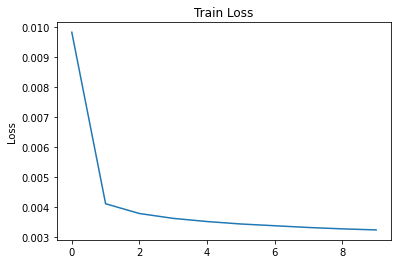

In [93]:
make_dir(PATH_TRAIN)
make_dir(PATH_GRAPH)
net,train_loss = train(net, trainloader, NUM_EPOCHS,PATH_TRAIN)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_train.png')

TODO_ comentar

  0%|          | 4/3000 [00:00<01:17, 38.44it/s]

Epoch 1 of 10, Train Loss: 0.003


  0%|          | 4/3000 [00:00<01:34, 31.87it/s]

Epoch 2 of 10, Train Loss: 0.003


  0%|          | 3/3000 [00:00<01:43, 29.06it/s]

Epoch 3 of 10, Train Loss: 0.003


  0%|          | 2/3000 [00:00<02:31, 19.85it/s]

Epoch 4 of 10, Train Loss: 0.003


  0%|          | 4/3000 [00:00<01:27, 34.35it/s]

Epoch 5 of 10, Train Loss: 0.003


  0%|          | 4/3000 [00:00<01:32, 32.28it/s]

Epoch 6 of 10, Train Loss: 0.003


  0%|          | 2/3000 [00:00<02:39, 18.75it/s]

Epoch 7 of 10, Train Loss: 0.003


  0%|          | 4/3000 [00:00<01:15, 39.71it/s]

Epoch 8 of 10, Train Loss: 0.003


  0%|          | 5/3000 [00:00<01:16, 39.26it/s]

Epoch 9 of 10, Train Loss: 0.003


100%|██████████| 3000/3000 [01:18<00:00, 38.13it/s]


Epoch 10 of 10, Train Loss: 0.003


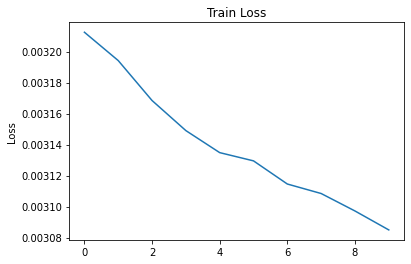

In [113]:
make_dir(PATH_TEST) 
#graphs = test_image_reconstruction(net, testloader,PATH_TEST)
net,test_loss = train(net, testloader, NUM_EPOCHS,PATH_TEST)
plt.figure()
plt.plot(test_loss)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_test.png')

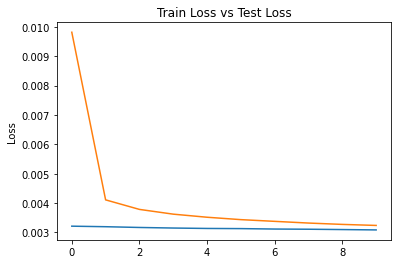

In [114]:
plt.figure()
plt.plot(test_loss)
plt.plot(train_loss)
plt.title('Train Loss vs Test Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_test_train.png')

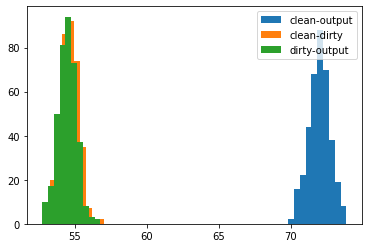

In [115]:
plt.hist(graphs[0],  linewidth=1, label ='clean-output')
plt.hist(graphs[1],  linewidth=1, label = 'clean-dirty')
plt.hist(graphs[2], linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.savefig(PATH_GRAPH+'/graph_psnr.png')
plt.show()


